In [10]:
%pip install lenskit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

In [2]:
import pandas as pd

In [3]:
# ratings = pd.read_csv('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest-small/ratings.csv')
ratings = pd.read_csv('/scratch/work/courses/DSGA1004-2021/movielens/ml-latest/ratings.csv')


In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [5]:
ratings.columns = ratings.columns.str.replace('userId', 'user')
ratings.rename(columns = {'userId':'user', 'movieId':'item'}, inplace = True)

In [6]:
ratings

,user,item,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [7]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [ ]:
all_recs = []
test_data = []
start_time = time.time()
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
    
    
finish_time = time.time()
print("----- %s seconds -----", finish_time - start_time)

            user   item  rating
0              1    307     3.5
1              1    481     3.5
2              1   1091     1.5
3              1   1257     4.5
4              1   1449     4.5
...          ...    ...     ...
27753439  283228   8542     4.5
27753440  283228   8712     4.5
27753441  283228  34405     4.5
27753442  283228  44761     4.5
27753443  283228  54286     4.5

[26647045 rows x 3 columns]


In [33]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,5919,5.906250,4,1,ItemItem
1,127096,5.033268,4,2,ItemItem
2,64197,4.952017,4,3,ItemItem
3,3075,4.941815,4,4,ItemItem
4,92643,4.928817,4,5,ItemItem


In [34]:
test_data = pd.concat(test_data, ignore_index=True)

In [35]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  4       100  0.031975
          19      100  0.000000
          26      100  0.000000
          27      100  0.000000
          28      100  0.000000

In [36]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.077122
ItemItem    0.003968
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

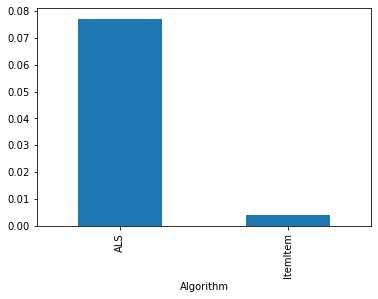

In [37]:
results.groupby('Algorithm').ndcg.mean().plot.bar()